# Independent Component Analysis (ICA)

Author: Duncan Kirby

### Details <a id='linkDetails'></a>

ICA is a technique, closely related to PCA, which maximizes indepence rather than variance in the projected data. The choice of statistical definition of independence determines the method of ICA. Two broad types of independence are minimization of mutual information, and maximization of non-Gaussianity. We'll look at non-Gaussianity in this notebook.

To define the problem, consider a source vector due to $n$ sources $\textbf{s} \in \mathbb{R}^{n}$. We observe $\textbf{x} = \textbf{As}$ where $\textbf{A}$ is an unknown mixing matrix of size $m\times n$. This is often introduced in the context of the cocktail party.

> The cocktail party problem: Imagine having $m$ microphones set up during a cocktail party with $n$ people. Then $s^{(i)}$ is    the sound at time $i$ and $s_{j}^{(i)}$ is the voice of the $j$th guest. Similarly,  $x^{(i)}$ is the audio signal recorded      by the room of microphones at time $i$ and $x_{j}(t)$ is the recording of the $j$th microphone. The problem is to find the    unmixing matrix $\textbf{A}^{-1}$ and reproduce \textbf{s} given only $x(t)$, for $m \leq n$ (clearly this problem is only    guaranteed to have a solution for $n=m$).


Our problem is to find the inverse transformation (now denoted as dependent on time $(t)$) $\textbf{s}(t) = \textbf{A}^{-1}\textbf{x}(t)$.

> #### Note:
There are inherent limitations to the abilities of ICA to discover the unmixing matrix, mostly due to the fact that because both $\textbf{s}$ and $\textbf{A}$ are unknown. First of all, the solution is ambiguous to permutations, ie.
$$
\textbf{x} = \textbf{As} = \textbf{AP}^{-1}\textbf{Ps}
$$
where $\textbf{P}$ is a permutation matrix and $\textbf{P}^{-1}\textbf{P} = \textbf{I}$. This means that the order of the source vector components cannot be reconstructed reliably, because there is no way to distinguish between $\textbf{W}$ and $\textbf{PW}$. Usually this is not important but it may be relevant to biological applications.

> Similarly, there is no way to distinguish between carefully scaled versions of the inverse problem, such as
$$
\textbf{x} = \textbf{As} = 2\textbf{A}\frac{1}{2}\textbf{s} .
$$
This is even true if one only scales a single column of $\textbf{A}$ and the corresponding element of $\textbf{s}$. Once again, this is not generally a concern in the literature but may be so for biologists. The consequence of this ambiguity is that we cannot uniquely determine variances of independent components.

> Finally, there is another ambiguity for rotationally invariant sources (eg. $\textbf{s} \in \mathcal{N}(0,I)$ for $I$ the identity covariance matrix). In this case we could apply an orthogonal transformation $\textbf{R}$ (a rotation/reflection matrix) to $\textbf{A}$ to produce $\textbf{A}^{\prime}=\textbf{AR}$ and the mixed data would still be distributed normally (ie. would have the same mean and covariance matrix). To see this, note that for data with zero mean and covariance
\begin{align*}
\Sigma(\textbf{x}) &= \textbf{Ass}^{T}\textbf{A}^{T}\\
&= \textbf{A}\textbf{A}^{T}
\end{align*}
the covariance of the rotated data would be, since the sources are assumed independent in ICA,  
\begin{align*}
\Sigma(\textbf{x}^{\prime}) &= \textbf{RAss}^{T}\textbf{R}^{T}\textbf{A}^{T}\\
&= \textbf{AR}\textbf{R}^{T}\textbf{A}^{T}\\
&= \textbf{A}\textbf{A}^{T}.
\end{align*}

### FastICA Algorithm
The most common implementation of ICA for maximizing non-gaussianity (remember that there are other choices for measuring independence) is the FastICA algorithm, which maximizes the absolute value of kurtosis in the transformed data space. That is to say, given our current estimate of $\bf{W}=\bf{A}^{-1}$ for solving $\bf{X}=\bf{As}$, we say that this estimate is good if it is a local maximum of the function $\text{kurt}(\textbf{WX})$.

> Notes on the properties of kurtosis:
Definition of kurtosis:  Begin by defining the $\textit{characteristic function}$ of random variable $x$ as the Fourier transform of the pdf $p_{x}(x)$:
$$
\varphi(\omega)=E[\text{exp}(i\omega x)] = \int_{-\infty}^{\infty}\text{exp}(i\omega x)p_{x}(x)dx
$$
The $\textit{second characteristic function}$ is the logarithm of the first, and is also called the cumulant generating function (cgf).
$$
\phi(\omega)=\text{ln}(E[\text{exp}(i\omega x)])
$$
The cgf can be expanded as a Taylor series
$$
\phi(\omega)=\sum_{k=0}^{n}\frac{(i\omega)^{k}}{k!}(-i)^{k}\frac{d^{k}\phi(\omega)}{d\omega^{k}}\Bigr|_{\omega=0}
$$
The $k^{th}$ cumulant is defined to be the coefficient of this series:
$$
\kappa_{k} = (-i)^{k}\frac{d^{k}\phi(\omega)}{d\omega^{k}}\Bigr|_{\omega=0}
$$

>Kurtosis is the fourth cumulant, which is also the first cumulant to not be equal to its corresponding moment (for zero mean random variables):
$$\kappa_{4} = E[x^{4}]-3(E[x^{2}])^{2}$$ Things get messier for random variables with non-zero mean or for higher dimensional random variables, but the principles are the same. 

> Some important properites of kurtosis are additivity and scaling:
$$\text{kurt}(x+y) = \text{kurt}(x)+\text{kurt}(y) \\
\text{kurt}(\beta x) = \beta^{4}\text{kurt}(x)  .
$$


Normal gradient descent following $\frac{\partial | \text{kurt}(w^{T} X)|}{\partial w}$ converges slowly. FastICA is derived by noting that at a maxima of our cost function $J = | \text{kurt}(w^{T} X)|$, the gradient $\frac{\partial J}{\partial w}$ points in the same direction as $w$. Since we will normalize $w$ once we have our solution anyway, we don't care about the scale factor between $w$ and the gradient. This means we can equate $w$ with the gradient of kurtosis to quickly converge to a local maximum:
$$
w \propto E[X(w^{T}X)^{3}]-3w|w|^{2}
$$
While this may seem a bit ridiculous, in practice it seems to work well and it can be proven that it the convergence is cubic, which is fast. Note that the expectations must be estimated in practice.

#### Algorithm
Each component $w$ of the transformation matrix is found successively. To find a component $w$ such that non-Gaussianity is maximized for $w^{T}X$ ($X \in \mathbb{R}^{N\times M}$ is the data matrix of $N$ sources recorded at $M$ times), perform the following steps:

1. Randomize the initial weight vector $w$
2. Set $w^{+} = E[X(w^{T}X)^{3}]-3w$ where $E()$ means take the column-average of $X$
3. Normalize: $w = \frac{w^{+}}{|w^{+}|}$
4. Repeat steps 2 and 3 until converged (ie. $w$ does not change upon further iteration)

There are, generally speaking, improvements and special cases for this solution. For more information, try $\textit{Independent Component Analysis}$ by Aapo Hyv¨arinen, Juha Karhunen, and Erkki Oja

### A quick example of implementation

Source: http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html
Date of access: 26-10-2018

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000

Generate signals with noise added

In [5]:
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data

Mix the signals using a mixing matrix

In [6]:
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)

Compute the ICA

In [7]:
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

 We can show that the ICA model applies by reverting the unmixing

In [8]:
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

For comparison, compute PCA

In [9]:
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

Plot the results

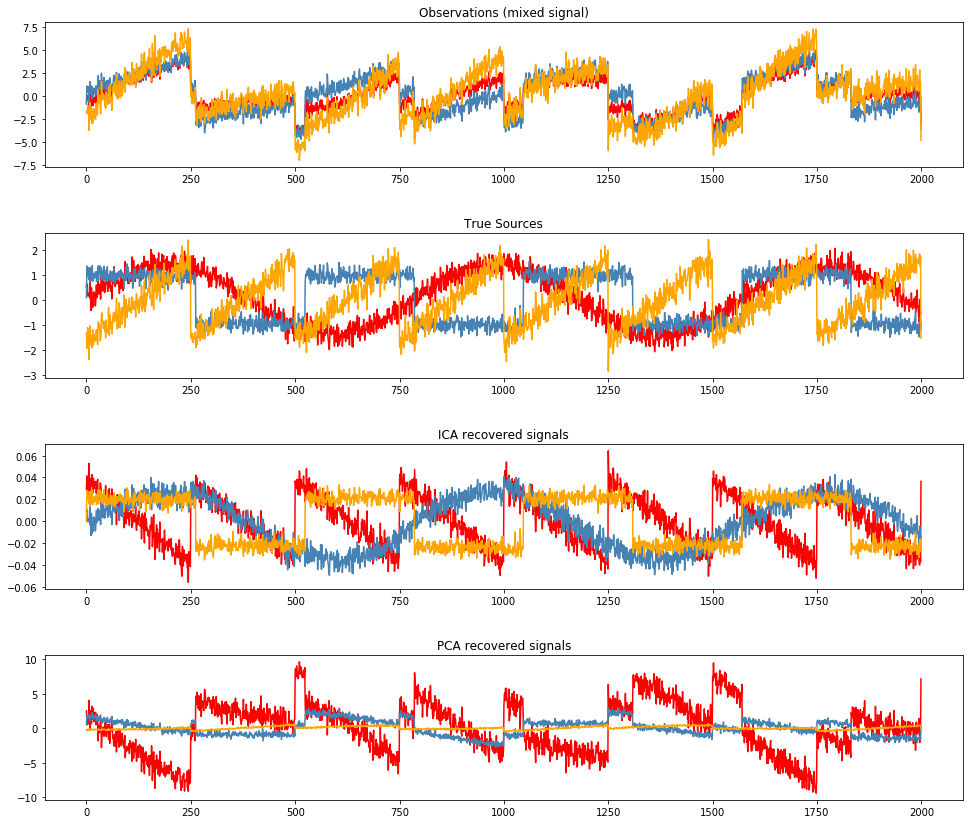

In [14]:
plt.figure(figsize=(15,12))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()